In [1]:
# this was necessary to install the imputeLCMD package

# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install(c("pcaMethods", "impute"))

# install.packages("imputeLCMD")

In [2]:
# specifying the location of files to be exported on my computer
Output = ("/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1007. Sputum Proteomics/P1007.3. Analyses/P1007.3.1. Data Processing/Output")

# it's always a good idea to update the date every time the file is modified
cur_date = "112822"

# loading packages
library(readxl)
library(tidyverse)
library(imputeLCMD)
library(factoextra)

# reading in files
demographics_df = data.frame(read_excel("Input/SubjectInfo_100422.xlsx", sheet = 2))
proteomics_df = data.frame(read_excel("Input/Proteomics_Data_100422.xlsx", sheet = 2))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: tmvtnorm

Loading required package: mvtnorm

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: stats4

Loading required package: gmm

Loading required package: sandwich

Loading required package: norm

This package has some major limitations
(for example, it does not work reliably when
the number of variables exceeds 30),
and has been superseded by the norm2 package.

Loading required package: pcaMethods

Loading required package: Biobase

Loading require

In [3]:
# let's view our data
head(demographics_df)
head(proteomics_df)

,Original_Subject_Number,Proteomic_Core_Subject_Number,Subject_Number,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Asthma_Status,Pre_Sputum_Neutrophilia,Post_Sputum_Neutrophilia,Responder_Status
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,1,1,1,NR_1,M,B,NH,37,26.0,NAS,77.20,74.49,NR
2,6,3,2,NR_2,F,W,NH,26,21.9,NAS,22.60,0.00,NR
3,11,9,3,NR_3,M,W,NH,33,23.9,NAS,68.39,0.00,NR
4,16,15,4,NR_4,F,W,NH,30,23.3,NAS,34.63,22.72,NR
5,23,23,5,NR_5,M,As,NH,29,19.6,NAS,28.60,79.70,NR
6,28,29,6,NR_6,F,W,NH,31,21.1,NAS,50.00,0.00,NR


,Protein_Accession,Gene_Name,Protein_Descriptions,Protein_Name,Number_Unique_Peptides,NR_1.Post_1,NR_1.Pre_2,NR_2.Post_3,NR_2.Pre_4,R_16.Post_5,⋯,NR_15.Post_45,NR_15.Pre_46,R_26.Post_47,R_26.Pre_48,R_28.Post_49,R_28.Pre_50,NR_10.Post_51,NR_10.Pre_52,NR_11.Post_53,NR_11.Pre_54
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,64819128,88131664,30396704,38267072,68394088,⋯,101923184,60452100,80559896,58957400,76130320,74376768,65792688,194960864,69929272,78145128
2,P01877,IGHA2,Immunoglobulin heavy constant alpha 2,IGHA2_HUMAN,26,22060250,42064988,15816474,13573791,41635244,⋯,25832360,17997114,51021916,33093636,31312154,27951066,47788776,50067800,87764504,50257404
3,P01876,IGHA1,Immunoglobulin heavy constant alpha 1,IGHA1_HUMAN,19,15479590,37625912,10208903,17411216,26743002,⋯,32377382,16222550,45050984,25297714,26496618,22352402,35715656,48121812,34948236,26980310
4,P02768,ALB,Albumin,ALBU_HUMAN,111,24605874,15046185,3849758,10269878,37167876,⋯,23754696,35173596,12769630,12790221,12739557,20100892,25795572,53819984,11479106,33682988
5,P01834,IGKC,Immunoglobulin kappa constant,IGKC_HUMAN,3,10251611,23780070,5838666,11111163,17627460,⋯,20500068,17385894,21898422,15646760,17069230,7808116,12224238,26033636,8252182,17545114
6,P0DTE7;P0DTE8;P0DUB6,AMY1B;AMY1C;AMY1A,Alpha-amylase 1B;Alpha-amylase 1C;Alpha-amylase 1A,AMY1B_HUMAN;AMY1C_HUMAN;AMY1A_HUMAN,43,15135001,4211979,121132528,12570474,4974127,⋯,3932507,4589779,12964920,20496752,9089169,20601276,7792469,21065250,2210601,7292686


# 1. Removing Subject Outliers

Our `demographics_df`contains 3 subjects (NR_4, NR_9, and R_27) that were deemed as outliers and need to be removed. (This was due to blood contamination and low expression.) The `filter`function will be used to remove these three subjects.

In [4]:
# creating a vector with the subject ids of the outliers
outlier_subjects = c("NR_4", "NR_9", "R_27")

# creating a variable that does the opposite of '%in%'
`%notin%` = Negate(`%in%`)

# removing outliers using the filter function
demographics_df_no_outliers = demographics_df %>%
    # filtering for subjects not in the outlier_subjects vector
    filter(Subject_ID %notin% outlier_subjects)

#let's check to see if they were removed
dim(demographics_df)
dim(demographics_df_no_outliers)

[1] 30 13

[1] 27 13

The `dim` function provides the length (first number) and width (second number) of our data. Since, each subject has one row of information we can see that we now have 3 fewer subjects. 

# 2. Peptide Normalization

Biologically speaking, proteomics normalization is to "correct for variability that is not coming from the biological system itself, but from th experimental process" [ref](https://help2.biognosys.com/portal/en/kb/articles/how-is-my-data-normalized-in-spectronaut#:~:text=Default%20normalization%20in%20Spectronaut,-Spectronaut%20default%20settings&text=This%20default%20normalization%20is%20based,peptides%20up%20and%20down%20regulated). Statistically speaking, normalization is used to put all variables on the same scale between 0 and 1. We normalize to total amount of peptide per sample by: 

1. Summing the abundance values for each sample
2. Calculating the median value across all of the summed abundance values
3. Calculating the ratio

In [5]:
# merging the demographics_df and proteomics_df but doing some reshaping first
# telling the pivot_longer function to only pivot the concentration data (columns 6 through 61)
# the two columns for the names and values can be renamed 
longer_proteomics_df = pivot_longer(proteomics_df, cols = 6:59, names_to = "Subject_ID.Sample_ID", 
                                    values_to = "Intensity")

# viewing data
head(longer_proteomics_df)

Protein_Accession,Gene_Name,Protein_Descriptions,Protein_Name,Number_Unique_Peptides,Subject_ID.Sample_ID,Intensity
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_1.Post_1,64819128
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_1.Pre_2,88131664
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_2.Post_3,30396704
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_2.Pre_4,38267072
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,R_16.Post_5,68394088
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,R_16.Pre_6,50484084


In [6]:
longer_proteomics_separated_df = longer_proteomics_df %>%
    # in the separate function a period needs to be specified by "\\." not "."
    # the second parameter is used to specify the new column names
    separate(Subject_ID.Sample_ID, c("Subject_ID", "Sample_ID"), sep = "\\.")

# viewing data
head(longer_proteomics_separated_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 2244 rows [7, 61, 115, 169, 223, 277, 331, 385, 439, 493, 547, 601, 655, 709, 763, 817, 871, 925, 979, 1033, ...].”


Protein_Accession,Gene_Name,Protein_Descriptions,Protein_Name,Number_Unique_Peptides,Subject_ID,Sample_ID,Intensity
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_1,Post_1,64819128
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_1,Pre_2,88131664
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_2,Post_3,30396704
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_2,Pre_4,38267072
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,R_16,Post_5,68394088
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,R_16,Pre_6,50484084


In [7]:
# # removing the original subject no. and proteomic core subject no. since they're no longer needed
# proteomics_demographics_df = inner_join(demographics_df, longer_proteomics_separated_df)[,3:20]

# # viewing data
# head(proteomics_demographics_df)

In [8]:
normalized_df = longer_proteomics_separated_df %>%#proteomics_demographics_df %>%
    # grouping by sample
    group_by(Sample_ID) %>%
    # taking the sum of the intensities for each sample
    mutate(Summed_Value = sum(Intensity)) %>%
    # calculating median across all samples 
    ungroup() %>%
    mutate(Median_of_Sum = median(Summed_Value), Norm_Factor = Summed_Value/ Median_of_Sum, 
           Norm_Intensity = Intensity/Norm_Factor) %>%
    # using the select function to remove columns we no longer need
    select(-c("Summed_Value", "Median_of_Sum", "Norm_Factor"))

# viewing data
head(normalized_df)

Protein_Accession,Gene_Name,Protein_Descriptions,Protein_Name,Number_Unique_Peptides,Subject_ID,Sample_ID,Intensity,Norm_Intensity
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_1,Post_1,64819128,73788698
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_1,Pre_2,88131664,81867432
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_2,Post_3,30396704,32521080
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_2,Pre_4,38267072,69466047
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,R_16,Post_5,68394088,67261698
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,R_16,Pre_6,50484084,54090669


# 3a. Detection Filter

Retaining proteins that were identified by at least 2 peptides. 

In [9]:
# only keeping proteins > 2 unique proteins
detection_filter_1_df = normalized_df %>%
    filter(Number_Unique_Peptides > 2) #%>%
    # creating a treatment col
    #mutate(Sample_ID2 = Sample_ID) %>%
    #separate(Sample_ID2, c("Exposure", NA), sep = "_")
head(detection_filter_1_df)

# determining how many proteins are kept for each exposure group
detection_filter_1_df %>%
    #group_by(Exposure) %>%
    summarize(`Remaining Proteins` = length(unique(Protein_Accession)))

Protein_Accession,Gene_Name,Protein_Descriptions,Protein_Name,Number_Unique_Peptides,Subject_ID,Sample_ID,Intensity,Norm_Intensity
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_1,Post_1,64819128,73788698
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_1,Pre_2,88131664,81867432
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_2,Post_3,30396704,32521080
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_2,Pre_4,38267072,69466047
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,R_16,Post_5,68394088,67261698
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,R_16,Pre_6,50484084,54090669


Remaining Proteins
<int>
1878


In [10]:
# figuring out the number of proteins that were removed
length(unique(normalized_df$Protein_Accession)) - length(unique(detection_filter_1_df$Protein_Accession))

[1] 366

# 3b. Detection Filter

Filter rows based on valid values: 50 % valid in either pre or post woodsmoke exposure (i.e. proteins with values observed in fewer than 50% of samples in at least 1 condition were eliminated from the dataset)

In [11]:
protein_presence_df = detection_filter_1_df %>%
    # creating 2 count cols: 1st for non-missing data, 2nd for all data
    mutate(data_count = ifelse(is.na(Intensity), 0, 1), all_count = 1) %>%
    group_by(Protein_Accession) %>%
    summarize(Protein_Presence = sum(data_count)/ sum(all_count) * 100) %>%
    filter(Protein_Presence < 50) %>%
    arrange(Protein_Presence) 

head(protein_presence_df)

Protein_Accession,Protein_Presence
<chr>,<dbl>


This empty tibble indicates that there were no proteins that had missing data for more than 50% of samples. 

In [12]:
# let's see if there's any missing data
dim(detection_filter_1_df)
dim(drop_na(detection_filter_1_df))

[1] 101412      9

[1] 101142      9

The `drop_na` function would have dropped any missing data, but since the dimensions are the same no data is missing. When data is missing often times proteomics data can be imputed or generated, but for this analysis that step will be skipped. 

# 4. Additional Test for Outliers using PCA

For this task, we're interested in identifying subject outliers based on protein concentrations.

To test for outliers, often times **Principal Component Analysis (PCA)** is employed. PCA works by seeking to preserve the maximum amount of variance or information, while compressing it into the fewest number of dimensions or eigenvectors as possible. By reducing the number of dimensions of our data, this will make it easier to visualize, interpret, and therefore identify outliers. We'll use the `prcomp` function to run PCA. 

In [13]:
# prepping df for PCA
pca_prep_df = detection_filter_1_df %>%
    # selecting columns of interest
    select(c("Sample_ID", "Protein_Accession", "Norm_Intensity")) %>%
    pivot_wider(names_from = Protein_Accession, values_from = Norm_Intensity) %>%
    column_to_rownames(var = "Sample_ID")

head(pca_prep_df)

,P61626,P01877,P01876,P02768,P01834,P0DTE7;P0DTE8;P0DUB6,Q8TDL5,Q9UGM3,P0DOX8,P01036,⋯,Q14703,O00442,Q9H9S4,Q9Y315,Q8TCX1,Q9UKK3,Q9UFN0,P42331,Q8N5I3,Q9Y224
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Post_1,73788698,25112913,17621631,28010796,11670213,17229359,19583226,19462840,9302891,1440413.7,⋯,786.8603,922.4306,552.1628,789.2795,1178.6784,1117.9351,757.9924,998.9239,918.9834,634.0669
Pre_2,81867432,39075088,34951534,13976731,22089828,3912600,22772962,17870180,15587185,579220.2,⋯,788.0510,878.7856,213.6198,1193.4807,2430.1370,541.2620,457.6227,651.5910,488.9264,783.8629
Post_3,32521080,16921861,10922386,4118812,6246720,129598281,2628426,3409362,4515726,78655906.7,⋯,456.8497,471.2095,713.5137,390.3077,274.5893,471.2881,382.1680,342.8398,350.4611,541.6597
Pre_4,69466047,24640443,31606503,18642864,20170045,22819126,14995205,16422429,10686640,12022748.9,⋯,820.1714,1071.6040,678.2593,622.0369,867.9893,714.7833,902.0164,1415.2599,1141.0596,838.0074
Post_5,67261698,40945896,26300222,36552493,17335605,4891771,1638243,5768000,14017499,9330024.5,⋯,451.9293,570.1758,250.6395,493.5448,1824.5557,534.9391,1106.3320,657.6201,522.0589,458.3191
Pre_6,54090669,17039382,9397192,40558192,12641799,9772147,2636206,10713205,6076883,11836399.5,⋯,1229.9310,1695.2199,2061.9185,4338.0350,2190.8360,4728.1241,1578.5912,918.5893,1435.1430,1795.3190


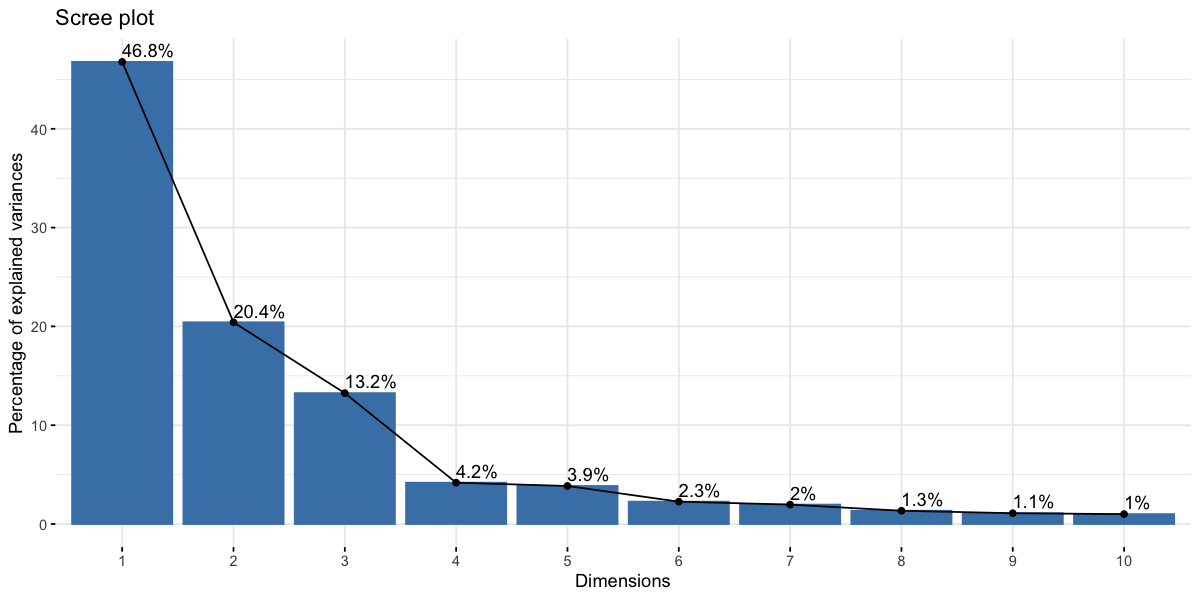

In [14]:
# running PCA
pca = prcomp(pca_prep_df)

# viewing scree plots to see how much of the variance was captured in first 2 eigenvectors
options(repr.plot.width=10, repr.plot.height=5) # changing size
fviz_eig(pca, addlabels = TRUE)

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


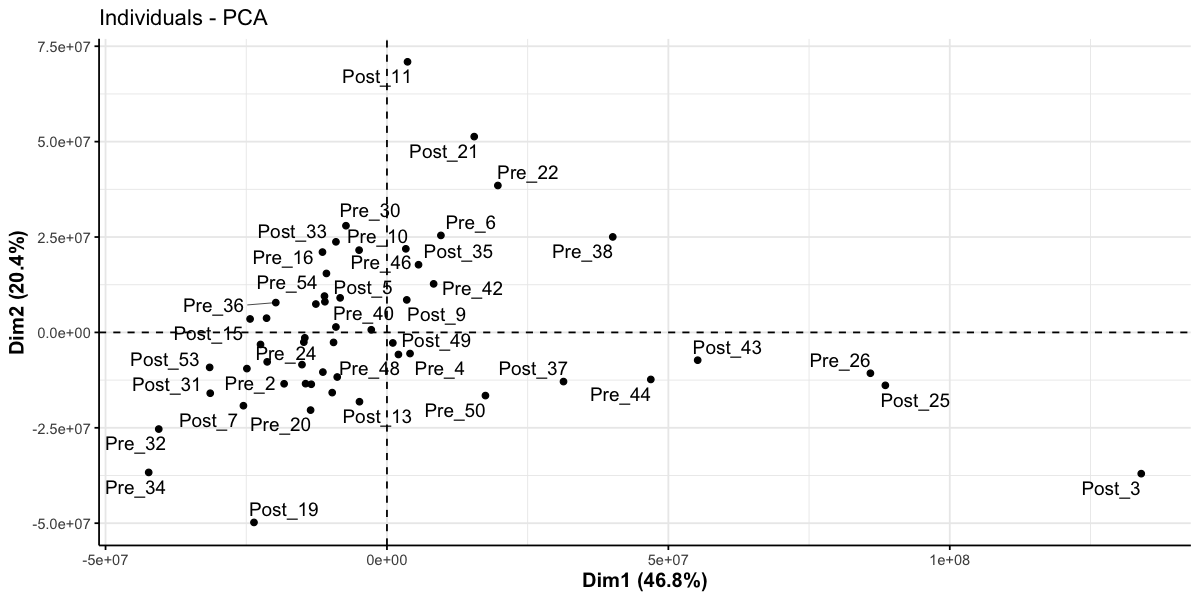

In [15]:
# visualizing all data to detect outliers
fviz_pca_ind(pca, 
             repel = TRUE) +
theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 8),
      axis.title = element_text(face = "bold", size = rel(1.1))) #changes axis titles

It looks like Post_3 should be removed, but let's use a quantitative cutoff to ensure others aren't missed. The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean” [ref](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/). 

In [16]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
outliers = outlier_detection(pca)
outliers

character(0)

There were no outliers based on the quantitative cut off, so no samples or subjects will be removed. Now we'll export a processed version of the proteomics data that was filtered and normalized. 

In [17]:
# exporting results
write.csv(detection_filter_1_df, paste0(Output,"/", "Processed_Proteomics_Data.csv"), row.names = FALSE)